# PerceptionLM: Open-Access Data and Models for Detailed Visual Understanding
Perception Language Model (PLM) is a state-of-the-art, fully open and reproducible MLLM for transparent research in image and video understanding.

[![Hugging Face Collection](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face%20Collection-Models,%20Data,%20and%20Benchmarks-blue)](https://huggingface.co/collections/facebook/perception-lm-67f9783f171948c383ee7498)
[![Paper](https://img.shields.io/badge/Technical%20Report-PerceptionLM-b31b1b.svg)](https://ai.meta.com/research/publications/perceptionlm-open-access-data-and-models-for-detailed-visual-understanding)
[![Paper](https://img.shields.io/badge/arXiv-2504.13180-brightgreen.svg?style=flat-square)](https://arxiv.org/abs/2504.13180)
[![ModelLicense](https://img.shields.io/badge/Model_License-FAIR_Research_License-lightgrey)](../../LICENSE.PLM)

### Log in HF hub

In [ ]:
from huggingface_hub.hf_api import HfFolder
# get your token here https://huggingface.co/settings/tokens
HfFolder.save_token('<Replace with your HF Token>')

/home/muhammadmaaz/anaconda3/envs/perception_models/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image
from PIL import Image, ImageDraw
from IPython.display import display, HTML
import textwrap
import time
import urllib

from core.args import dataclass_from_dict
from core.transforms.image_transform import get_image_transform
from core.transforms.video_transform import get_video_transform
from apps.plm.generate import PackedCausalTransformerGeneratorArgs, PackedCausalTransformerGenerator, load_consolidated_model_and_tokenizer

In [3]:
ckpt = "facebook/Perception-LM-1B"
# ckpt = "facebook/Perception-LM-3B"
# ckpt = "facebook/Perception-LM-8B"
model, tokenizer, config = load_consolidated_model_and_tokenizer(ckpt)

Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 90785.80it/s]

Downloaded to: /home/muhammadmaaz/.cache/huggingface/hub/models--facebook--Perception-LM-1B/snapshots/6dc1ed6a576954762676a7dc7aedb83b39b7a51a



INFO:apps.plm.tokenizer:Reloaded tiktoken model from /home/muhammadmaaz/.cache/huggingface/hub/models--facebook--Perception-LM-1B/snapshots/6dc1ed6a576954762676a7dc7aedb83b39b7a51a/tokenizer.model
INFO:apps.plm.tokenizer:#words: 128256 - BOS ID: 128000 - EOS ID: 128001
INFO:apps.plm.transformer:Initializing PE_VisionTransformer with args: {'image_size': 448, 'patch_size': 14, 'width': 1024, 'layers': 23, 'heads': 16, 'use_cls_token': True, 'use_abs_posemb': True, 'ls_init_value': 0.1, 'drop_path': 0.1, 'mlp_ratio': 4.0, 'use_ln_post': False, 'pool_type': 'none'}


In [4]:
def generate(
    media_path="",
    question="Describe the image in details.",
    media_type="image",
    number_of_tiles=1,
    temperature=0.0,
    top_p=None,
    top_k=None,
):
    prompts = []
    if media_type == "image":
        transform = get_image_transform(
            vision_input_type=(
                "vanilla" if number_of_tiles == 1 else config.data.vision_input_type
            ),
            image_res=model.vision_model.image_size,
            max_num_tiles=number_of_tiles,
        )
        image = Image.open(media_path).convert("RGB")
        image, _ = transform(image)
        prompts.append((question, image))
    elif media_type == "multi_image":
        assert len(media_path) > 1, f"The 'multi_image' is specified as media type, however the media contains only one image. Provide at least two images."
        transform = get_video_transform(
            image_res=model.vision_model.image_size,
        )
        images = [Image.open(path).convert("RGB") for path in media_path]
        processed_images, _ = transform._process_multiple_images_pil(images)
        prompts.append((question, processed_images))
    else:
        raise NotImplementedError(
            f"The provided generate function only supports image and video."
        )
    # Create generator
    gen_cfg = dataclass_from_dict(
        PackedCausalTransformerGeneratorArgs,
        {"temperature": temperature, "top_p": top_p, "top_k": top_k},
        strict=False,
    )
    generator = PackedCausalTransformerGenerator(gen_cfg, model, tokenizer)
    # Run generation
    start_time = time.time()
    generation, loglikelihood, greedy = generator.generate(prompts)
    end_time = time.time()
    for i, gen in enumerate(generation):
        # Calculate tokens per second
        total_tokens = sum(
            len(tokenizer.encode(gen, False, False)) for gen in generation
        )
        tokens_per_second = total_tokens / (end_time - start_time)
        print("=================================================")
        print(f"Question: {question}")
        print(f"Generation: {textwrap.fill(gen, width=75)}")
        print(f"Tokens per second: {tokens_per_second:.2f}")
        print("=================================================")

### Download and Preprocess the Image for Multi-Image Inference

In [5]:
imgURL = "http://images.cocodataset.org/val2017/000000281759.jpg"

urllib.request.urlretrieve(imgURL, "000000281759.jpg")

# We modify the image to place a red-dot on top right.
media_path = "000000281759.jpg"
media_path_modified = "000000281759_modified.jpg"

def add_red_dot(image_path, output_path, position=(10, 10), radius=5):
    # Open the image
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Define coordinates for the red dot
    x, y = position
    draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill="red")

    # Save the modified image
    image.save(output_path)
    print(f"Red dot added and saved to {output_path}")

# Add red dot on top-left of the image
add_red_dot(media_path, media_path_modified, position=(50, 50))

Red dot added and saved to 000000281759_modified.jpg


### Run Inference on Multiple Images

In [6]:
def display_images_side_by_side(image_path1, image_path2):
    """
    Display two images side by side in a Jupyter Notebook.

    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.
    """
    # Create HTML to display images side by side
    html = f"""
    <div style="display: flex; justify-content: space-around;">
        <div>
            <img src="{image_path1}" style="max-width: 100%; height: auto;">
        </div>
        <div>
            <img src="{image_path2}" style="max-width: 100%; height: auto;">
        </div>
    </div>
    """

    # Display the images
    display(HTML(html))

In [7]:
display_images_side_by_side(media_path_modified, media_path)

question = "<image><image>What is the difference between two images."
print("Generating for multi-image input (each image uses a sinlge tile)...")
generate(media_path=[media_path_modified, media_path], question=question, media_type="multi_image")

INFO:root:ImageTransform size: 448


Generating for multi-image input (each image uses a sinlge tile)...
Question: <image><image>What is the difference between two images.
Generation: The two images are of the same people, but the first image has a red dot in
the top left corner.
Tokens per second: 21.50


### Concatenate Images Horizontally and Run Inference as a Single Image

An alternative approach to processing multiple images is to concatenate them horizontally. This allows you to treat them as a single image and use standard image inference with tiling.

In [8]:
def concatenate_images_horizontally(image_path1, image_path2, output_path):
    """
    Concatenate two images horizontally and save the result.
    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.
        output_path (str): Path to save the concatenated image.
    """
    # Open the images
    image1 = Image.open(image_path1)
    image2 = Image.open(image_path2)
    # Get dimensions
    width1, height1 = image1.size
    width2, height2 = image2.size
    # Create a new image with a width equal to the sum of both images' widths
    # and a height equal to the maximum height of the two images
    new_width = width1 + width2
    new_height = max(height1, height2)
    # Create a new blank image with the calculated dimensions
    new_image = Image.new('RGB', (new_width, new_height))
    # Paste the first image at the left
    new_image.paste(image1, (0, 0))
    # Paste the second image to the right of the first image
    new_image.paste(image2, (width1, 0))
    # Save the concatenated image
    new_image.save(output_path)

media_path_combined = "000000281759_combined.jpg"
concatenate_images_horizontally(media_path_modified, media_path, media_path_combined)

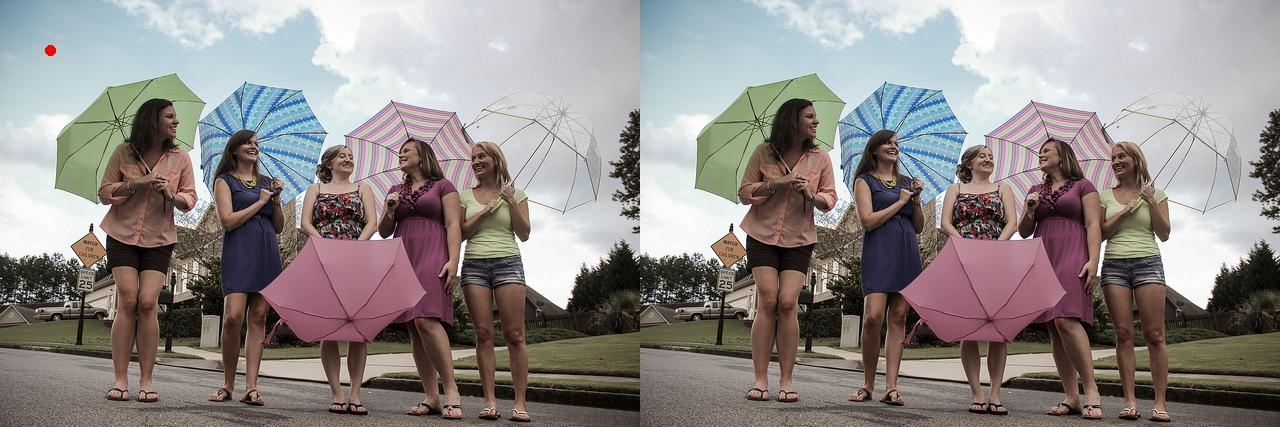

INFO:root:VariableSizeImageTransform size: 448
INFO:root:ImageTransform size: 448
INFO:root:Initalized transforms with: vision_input_type: 'thumb+tile' and max_num_tiles: 4.


Generating for multi-image input (images are concatenated horizonly and treated as a sinlge image with tiling)...
Generating with 4 tiles + 1 tumb...
Question: The image contains two images concatenated horizontly. What is the difference between the image on the left and the image on the right?
Generation: The image on the left has a red dot in the top left corner. The image on
the right does not.
Tokens per second: 53.82


In [9]:
display(Image.open(media_path_combined))

question = "The image contains two images concatenated horizontly. What is the difference between the image on the left and the image on the right?"
print("Generating for multi-image input (images are concatenated horizonly and treated as a sinlge image with tiling)...")
# with basic colab we can only run with with 1 to 4 tiles, instead of full 36 tiles.
# generate(media_path=media_path, question=question, media_type="image")
print("Generating with 4 tiles + 1 tumb...")
generate(media_path=media_path_combined, question=question, number_of_tiles=4, media_type="image")